In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data.csv
./model_data.csv
./Project_2.ipynb
./raw_data.csv
./zipCodeToLatLong.csv
./.ipynb_checkpoints/data-checkpoint.csv
./.ipynb_checkpoints/Project_2-checkpoint.ipynb
./.ipynb_checkpoints/model_data-checkpoint.csv
./.ipynb_checkpoints/raw_data-checkpoint.csv
./.ipynb_checkpoints/zipCodeToLatLong-checkpoint.csv
./models/base_gbr_model.pkl
./ScrapingChicago/raw_data_sold.csv
./ScrapingChicago/package.log
./ScrapingChicago/HomeHarvest_20250910_003045.csv
./ScrapingChicago/.gitignore
./ScrapingChicago/data.csv
./ScrapingChicago/raw_data.csv
./ScrapingChicago/scraper.ipynb
./ScrapingChicago/.ipynb_checkpoints/data-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/scraper-checkpoint.ipynb
./ScrapingChicago/.ipynb_checkpoints/HomeHarvest_20250910_003045-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/raw_data-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/raw_data_sold-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/df-checkpoint.csv


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Market prices are an important thing to consider when buying a house. This ML project aims to predict the price a house will be sold at given certain attributes. We must use data from public real estate websites and then build a property selling price predictor for a city, which is, in my case, Chicago. 

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

I used the Python Library HomeHarvest, which scrapes data from Realtors.com, Zillow, and Redfin. I used it to scrap for any homes sold, pending, or for sale in Chicago. Then, I saved the data as a csv. 

In [2]:
from homeharvest import scrape_property
from datetime import datetime

In [3]:
# current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# filename = f"HomeHarvest_{current_timestamp}.csv"

# sold_properties = scrape_property(
#     location="Chicago, IL",
#     listing_type="sold",
#     past_days=730,
# )
# print(f"Number of sold properties: {len(sold_properties)}")
# print(sold_properties.head())

In [4]:
# pending_properties = scrape_property(
#     location="Chicago, IL",
#     listing_type="pending",
#     past_days=730,
# )
# print(f"Number of pending properties: {len(pending_properties)}")
# print(pending_properties.head())

In [5]:
# for_sale_properties = scrape_property(
#     location="Chicago, IL",
#     listing_type="for_sale",
#     past_days=730,
# )
# print(f"Number of for sale properties: {len(for_sale_properties)}")
# print(for_sale_properties.head())

In [6]:
import pandas as pd

In [7]:
# df = pd.concat([sold_properties, pending_properties, for_sale_properties])
# print(len(df))

In [8]:
# df.to_csv("raw_data.csv", index=False)

In [9]:
df = pd.read_csv("raw_data.csv")

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

In [10]:
df = df[["property_id", "formatted_address", "zip_code", "style", "beds", 
                           "full_baths", "half_baths", "sqft", "year_built", 
                           "list_price", "sold_price", "latitude", "longitude", "stories"]]

df = df.dropna(subset=['zip_code', "list_price", "sold_price", "sqft", "beds", "full_baths"])
print(len(df))

df.drop_duplicates(inplace=True)
print(len(df))

10526
8928


In [11]:
df.to_csv("data.csv", index=False)

I've taken the dataset and some of the columns I've estimated will have the greatest value in this predictor. After dropping the nan values within a few important columns, my dataset is down to 10,383. After dropping all the duplicate values, I'm down to 8779 properties. This is a signifcant decrease from my original count of 22,719. 

A few of the columns I got are less important and will NOT be used for training, just identification purposes, like formatting address and property id. Zip code and style will need to be one-hot-encoded since they are categorical variables, and I'll combined full and half baths into a single baths column. 

In [12]:
import matplotlib.pyplot as plt

In [13]:
df["age"] = datetime.now().year - df["year_built"]
df.drop(columns="year_built", inplace=True)

In [14]:
def outlier_calc(data, val):
    q3 = data[f"{val}"].quantile(0.75)
    q1 = data[f"{val}"].quantile(0.25)
    iqr = q3 - q1
    print(f"outlier bounds: {q1 - 1.5 * iqr} to {q3 + 1.5 * iqr}")

    data = data[((q1 - 1.5 * iqr) <= data[f"{val}"]) & (data[f"{val}"] <= (q3 + 1.5 * iqr))]
    return data

In [15]:
# predicting sold price
print(df.info())
df_price = outlier_calc(df, "sold_price")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8928 entries, 0 to 23082
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   property_id        8928 non-null   int64  
 1   formatted_address  8928 non-null   object 
 2   zip_code           8928 non-null   int64  
 3   style              8928 non-null   object 
 4   beds               8928 non-null   float64
 5   full_baths         8928 non-null   float64
 6   half_baths         2472 non-null   float64
 7   sqft               8928 non-null   float64
 8   list_price         8928 non-null   float64
 9   sold_price         8928 non-null   float64
 10  latitude           8886 non-null   float64
 11  longitude          8886 non-null   float64
 12  stories            5412 non-null   float64
 13  age                8281 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 1.0+ MB
None
outlier bounds: -347500.0 to 1040500.0
<class 'pandas.core.fr

Calculating statistical outlier bounds gives us a sold price outlier of 0 - around 2 million. This is a very large range and is most likely due to Chicago's diverse housing market.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8928 entries, 0 to 23082
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   property_id        8928 non-null   int64  
 1   formatted_address  8928 non-null   object 
 2   zip_code           8928 non-null   int64  
 3   style              8928 non-null   object 
 4   beds               8928 non-null   float64
 5   full_baths         8928 non-null   float64
 6   half_baths         2472 non-null   float64
 7   sqft               8928 non-null   float64
 8   list_price         8928 non-null   float64
 9   sold_price         8928 non-null   float64
 10  latitude           8886 non-null   float64
 11  longitude          8886 non-null   float64
 12  stories            5412 non-null   float64
 13  age                8281 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 1.0+ MB


In [17]:
# convert to numbers

cols = df.columns.difference(['formatted_address', 'style'])
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [18]:
# look at the correlation between variables
corr_matrix = df.corr(numeric_only=True)
corr_matrix["sold_price"].sort_values(ascending=False)

sold_price     1.000000
list_price     0.616981
sqft           0.449857
full_baths     0.362112
half_baths     0.293416
beds           0.192323
latitude       0.162056
stories        0.063872
property_id    0.059206
longitude      0.043343
zip_code      -0.110921
age           -0.169590
Name: sold_price, dtype: float64

From this I can see that the things that effect the price the most are the size, number of rooms, and location. 

In [19]:
# # scatter matrix

# from pandas.plotting import scatter_matrix

# attributes = df.columns.difference(['formatted_address', 'property_id', 'style'])
# df["baths"] = df["full_baths"] + (df["half_baths"] * 0.5).bfill()
# df["numOfRooms"] = df["baths"] + df["beds"]

# scatter_matrix(df[attributes], figsize=(20,16))
# plt.show()

There are not a lot of super obvious trends from just this scatter matrix, which suggests that Chicago has a really diverse market and it might be hard to predict prices even with geolocation.

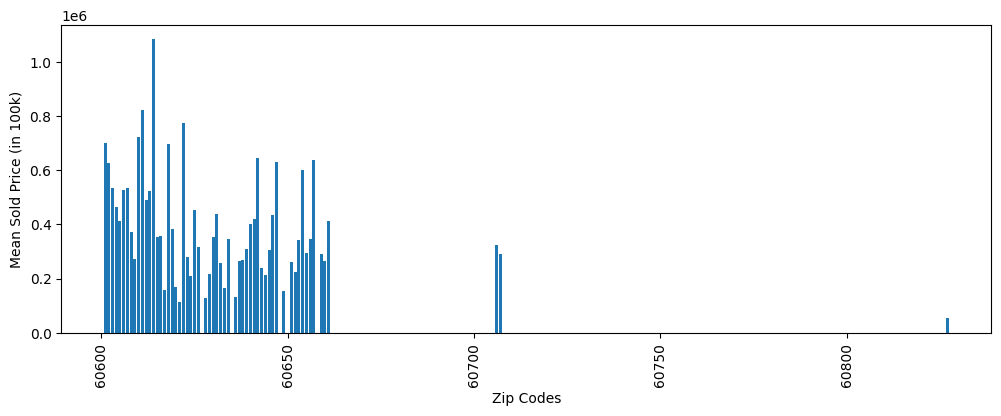

In [20]:
# zip_code vs. price
# would indicate richer zip codes

plt.figure(figsize=(12, 4))

grouped_data = df.groupby("zip_code", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["zip_code"], grouped_data["sold_price"])

plt.xticks(rotation=90)
plt.xlabel("Zip Codes")
plt.ylabel("Mean Sold Price (in 100k)")
plt.show()

The zipcodes need to be encoded.
The highest mean selling price has a zipcode of 60614, and the lowest is 60827. 

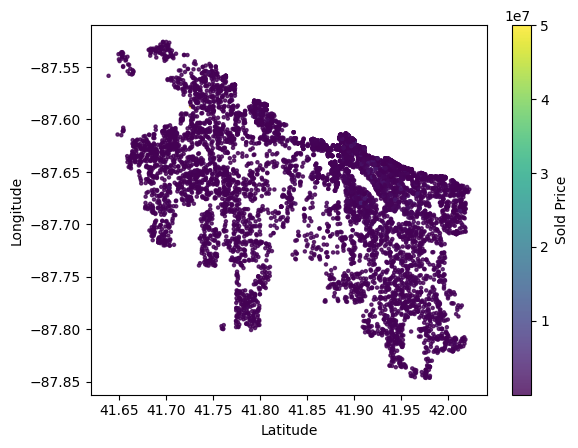

In [21]:
plt.scatter(df["latitude"], df["longitude"], c=df["sold_price"], cmap='viridis', s=5, alpha=0.8)
plt.colorbar(label='Sold Price')

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

This map traces out the shape of Chicago with all of the properties mapped using price as color. It's clear the majority of properties are just less or around 10^7 dollars. This may be a better alternative than using the zipcodes, although the numbers may vary a lot compared to using the zipcodes to "bin" the coordinates.

In [22]:
# lat and long for zip

lat_long_df = pd.read_csv("zipCodeToLatLong.csv")

df.rename(columns={"latitude": "zip_lat", "longitude": "zip_long"}, inplace=True)
df['zip_code'] = df['zip_code'].astype(int)
df = df.merge(lat_long_df, left_on="zip_code", right_on="zip", how="left")

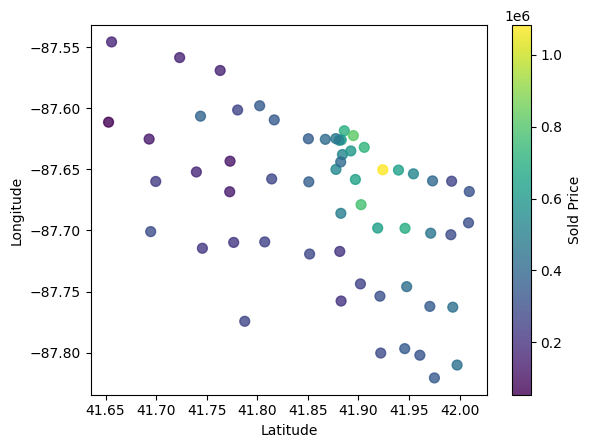

In [23]:
grouped_data = df.groupby("zip_code", as_index=False)[["sold_price", "zip_lat", "zip_long"]].mean()

plt.scatter(grouped_data["zip_lat"], grouped_data["zip_long"], c=grouped_data["sold_price"], cmap='viridis', s=50, alpha=0.8)
plt.colorbar(label='Sold Price')

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Grouping the data by zipcode gives us a clearer picture of where the richer areas of Chicago are (downtown). I still might use the raw latitudes and longitudes because they're more precise than this binning. 

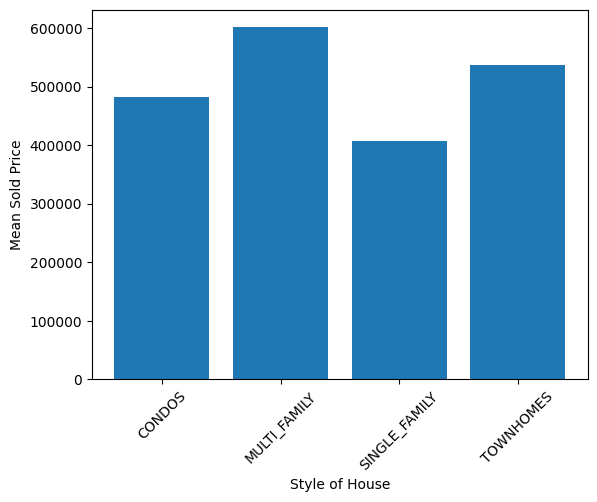

In [24]:
# style vs. price
# larger homes, pricier

grouped_data = df.groupby("style", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["style"], grouped_data["sold_price"])

plt.xticks(rotation=45)
plt.xlabel("Style of House")
plt.ylabel("Mean Sold Price")
plt.show()

The trends seem to make sense, with houses being higher than condos or single family houses. However, this metric might just be easier to figure out using the number of beds and baths.

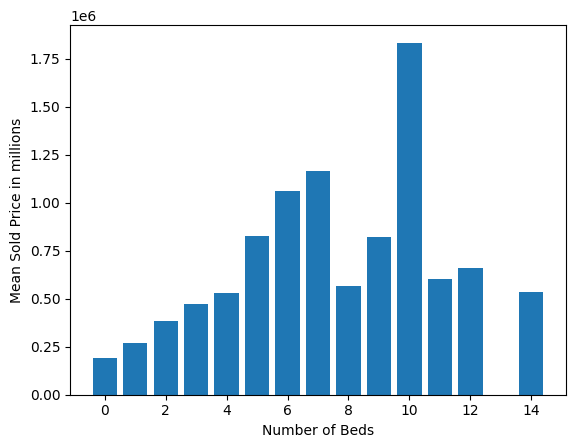

In [25]:
# beds vs. price
# more beds, higher price

grouped_data = df.groupby("beds", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["beds"], grouped_data["sold_price"])

plt.xlabel("Number of Beds")
plt.ylabel("Mean Sold Price in millions")
plt.show()

outlier bounds: 0.5 to 4.5


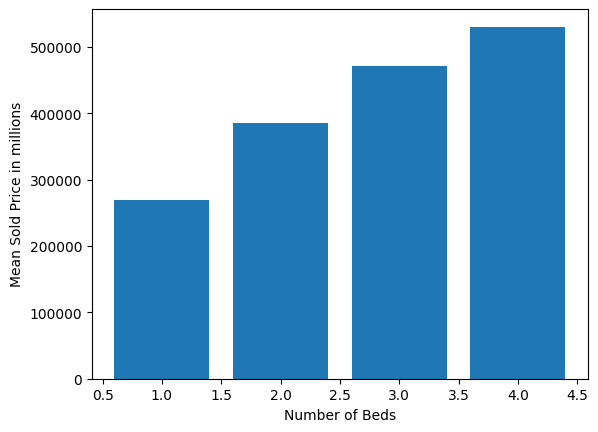

In [26]:
df_beds = outlier_calc(df, "beds")

grouped_data = df_beds.groupby("beds", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["beds"], grouped_data["sold_price"])

plt.xlabel("Number of Beds")
plt.ylabel("Mean Sold Price in millions")
plt.show()

The sold price does increase and act as intended until about 7 rooms, and then it starts to go a little weird. 10 rooms has the maximum mean sold price, but 8, 11, and 14, which are all supposed to be high according to the trend, are very low, about the same price as the 5 room properties.

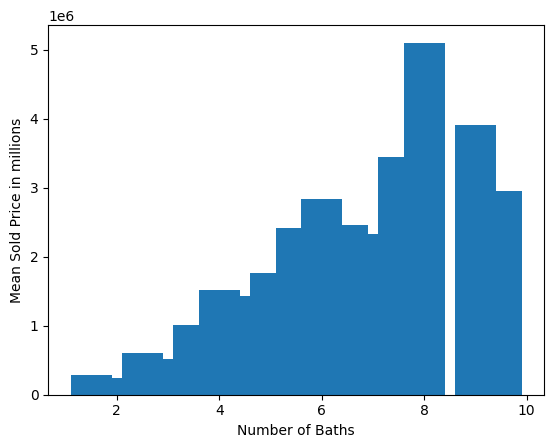

In [27]:
# baths vs. price
# more baths, higher price

df["baths"] = df["full_baths"] + 0.5 * df["half_baths"].bfill()

grouped_data = df.groupby("baths", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["baths"], grouped_data["sold_price"])

plt.xlabel("Number of Baths")
plt.ylabel("Mean Sold Price in millions")
plt.show()

outlier bounds: -1.5 to 6.5


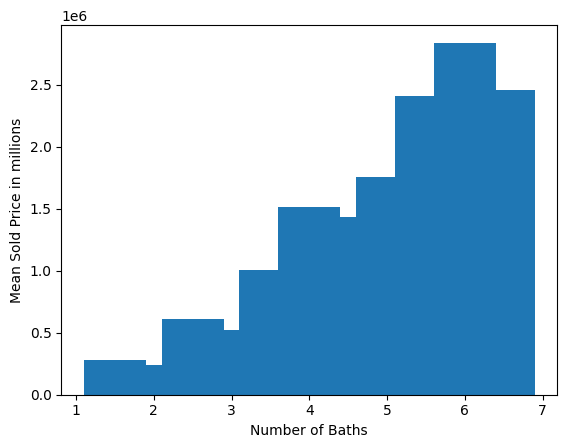

In [28]:
df_baths = outlier_calc(df, "baths")

grouped_data = df_baths.groupby("baths", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["baths"], grouped_data["sold_price"])

plt.xlabel("Number of Baths")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute does mostly follow the trend of increases rooms with increasing prices. It has a peak at around 8 baths. 

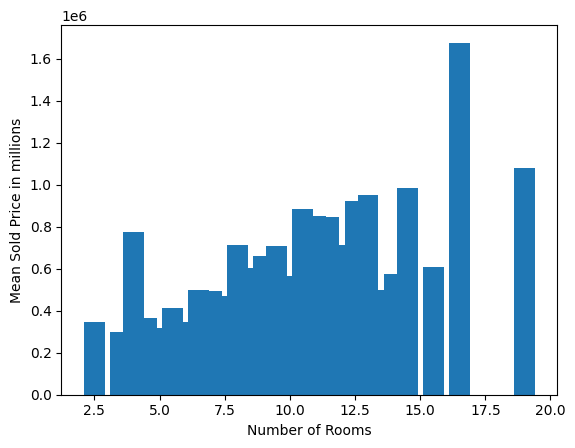

In [84]:
# combined bath + beds vs. sold price
# more rooms, higher price

df["numOfRooms"] = (df["baths"] + df["beds"]).bfill()

df["numOfRooms"] = df["numOfRooms"].replace(0, 1)

grouped_data = df.groupby("numOfRooms", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["numOfRooms"], grouped_data["sold_price"])

plt.xlabel("Number of Rooms")
plt.ylabel("Mean Sold Price in millions")
plt.show()

outlier bounds: 0.0 to 12.0


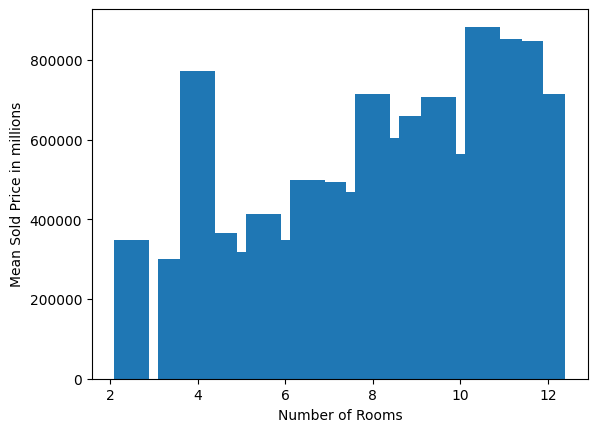

In [85]:
df_numOfRooms = outlier_calc(df, "numOfRooms")

grouped_data = df_numOfRooms.groupby("numOfRooms", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["numOfRooms"], grouped_data["sold_price"])

plt.xlabel("Number of Rooms")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This seems to follow the trend, but there are some odd lower values at some points, like at 16 and 24 rooms. Not sure why the trend doesn't apply at this higher room counts.

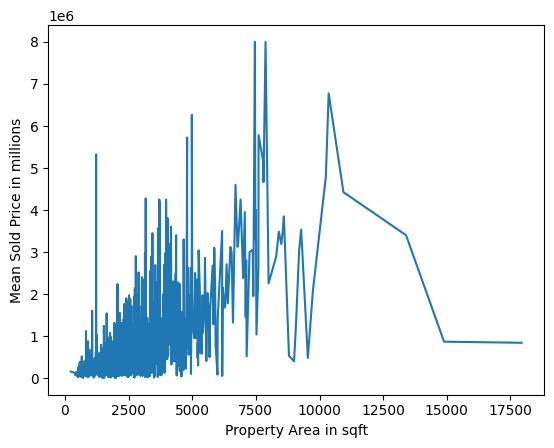

In [86]:
# sqft vs. sold price
# bigger house, higher price

grouped_data = df.groupby("sqft", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["sqft"], grouped_data["sold_price"])

plt.xlabel("Property Area in sqft")
plt.ylabel("Mean Sold Price in millions")
plt.show()

outlier bounds: -400.625 to 3472.375


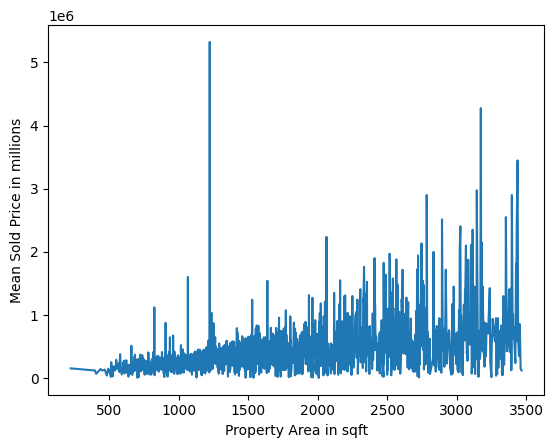

In [87]:
df_sqft = outlier_calc(df, "sqft")

grouped_data = df_sqft.groupby("sqft", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["sqft"], grouped_data["sold_price"])

plt.xlabel("Property Area in sqft")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute follows the trend as predicted. There are outliers for the properties with 15000 sqft which goes down, so it's a similar phenomenon as the bath and bed room issue of going down at extremely high values.

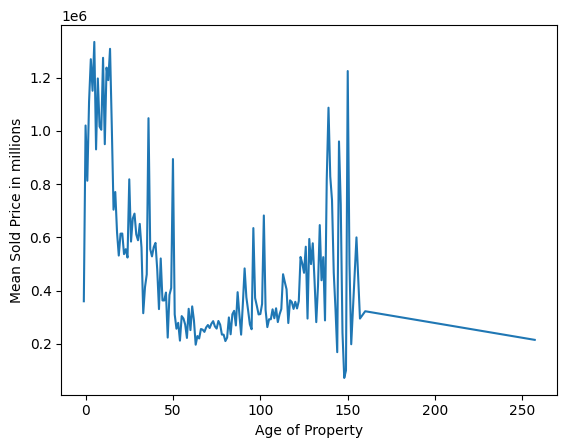

In [88]:
# age vs. sold price
# newer houses, higher price

grouped_data = df.groupby("age", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["age"], grouped_data["sold_price"])

plt.xlabel("Age of Property")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute has a lot of variation in the trend. The price is higher if the property is new, as expected, but it also seems to peak around 150 years in age, which might be able to be attributed to larger properties being older like historical buildings. 

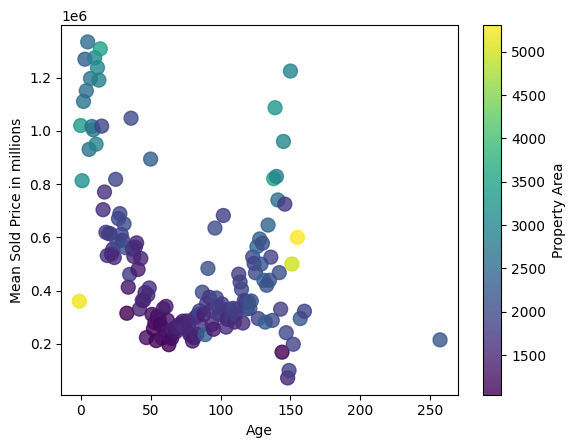

In [89]:
grouped_data = df.groupby("age", as_index=False)[["sold_price", "sqft"]].mean()

plt.scatter(grouped_data["age"], grouped_data["sold_price"], c=grouped_data["sqft"], cmap='viridis', s=100, alpha=0.8)
plt.colorbar(label='Property Area')

plt.xlabel("Age")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This second graph actually doesn't follow the trend I expected it would. There is no discernable correlation between property area and the age. Some newer properties are very large, and so are some that are around 150 years old. There is a single outlier with an age of 250 years, a medium-size area, and a low price.

outlier bounds: -91.5 to 216.5


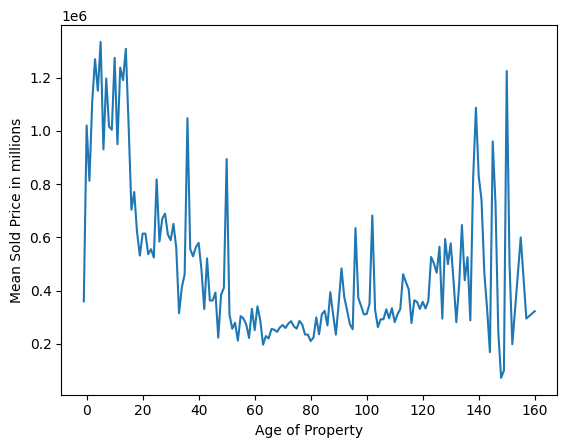

In [90]:
df_age = outlier_calc(df, "age")

grouped_data = df_age.groupby("age", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["age"], grouped_data["sold_price"])

plt.xlabel("Age of Property")
plt.ylabel("Mean Sold Price in millions")
plt.show()

In [91]:
df.columns = df.columns.str.strip()

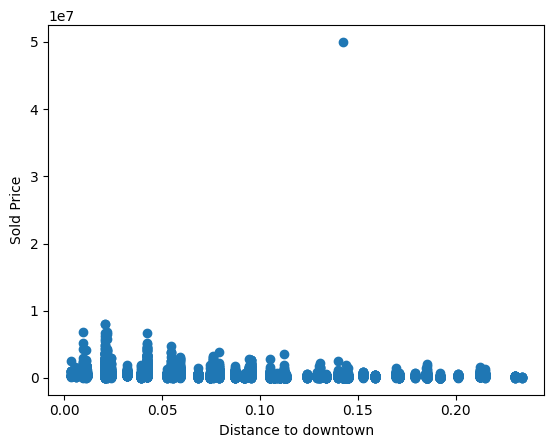

In [92]:
df["dist_to_downtown"] = ((df["latitude"] - 41.8832)**2 + (df["longitude"] + 87.6324)**2) ** 0.5

plt.scatter(df["dist_to_downtown"], df["sold_price"])

plt.xlabel("Distance to downtown")
plt.ylabel("Sold Price")
plt.show()

# 4.Prepare the Data


Apply any data transformations and explain what and why


After looking through the statistics, I've determined the features I'll be including to maximize prediction accuracy and minimize parameter count are number of rooms, property area, age, and geographic location. Although number of rooms and property area seem to follow very similar trends, so I might be able to not use that attribute.

In [108]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[['CONDOS', 'SINGLE_FAMILY', 'TOWNHOMES', 'MULTI_FAMILY']])
df['home_style'] = encoder.fit_transform(df[['style']])

In [109]:
# i've already dropped the nans
print(df.info())

model_df = df[["sold_price", "numOfRooms", "beds", "baths", "sqft", "age", "home_style", "latitude", "longitude", "stories", "zip_lat", "zip_long", "dist_to_downtown"]].convert_dtypes().fillna(0)
model_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8928 entries, 0 to 8927
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   property_id        8928 non-null   int64  
 1   formatted_address  8928 non-null   object 
 2   zip_code           8928 non-null   int64  
 3   style              8928 non-null   object 
 4   beds               8928 non-null   float64
 5   full_baths         8928 non-null   float64
 6   half_baths         2472 non-null   float64
 7   sqft               8928 non-null   float64
 8   list_price         8928 non-null   float64
 9   sold_price         8928 non-null   float64
 10  zip_lat            8886 non-null   float64
 11  zip_long           8886 non-null   float64
 12  stories            5412 non-null   float64
 13  age                8281 non-null   float64
 14  zip                8928 non-null   int64  
 15  latitude           8928 non-null   float64
 16  longitude          8928 

,sold_price,numOfRooms,beds,baths,sqft,age,home_style,latitude,longitude,stories,zip_lat,zip_long,dist_to_downtown
0,585000,4.5,2,0.0,1400,54,0,41.894742,-87.615073,0,41.90189,-87.625653,0.020819
1,345000,4.5,3,0.0,1766,77,1,41.946189,-87.806117,2,41.954683,-87.835812,0.184784
2,995000,4.5,2,0.0,1251,3,0,41.885155,-87.621512,0,41.886326,-87.614693,0.011062
3,420000,4.5,4,0.0,1788,28,1,41.714417,-87.555761,0,41.682921,-87.53921,0.185368
4,460000,4.5,2,0.0,1369,51,0,41.885155,-87.621512,0,41.8857,-87.6157,0.011062


In [110]:
model_df["stories"] = model_df["stories"].replace(0, 1)

I needed a way to encode the zipcodes since they are categorical but crucial to the price of a house (diff neighborhoods have diff prices), so I instead used latitude and longitude coordinates of the property. These are numerical so they should be better than doing one-hot-encoding and having way to many features, which would cause dimensionality issues (i have around 30 unique zipcodes).

In [111]:
# import scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [112]:
model_df = model_df[["sold_price", "sqft", "age", "zip_lat", "zip_long", "numOfRooms", "dist_to_downtown"]]

for x in ["sold_price", "sqft", "age", "zip_lat", "zip_long", "numOfRooms", "dist_to_downtown"]:
    model_df = outlier_calc(model_df, x)

print(model_df.info())

outlier bounds: -347500.0 to 1040500.0
outlier bounds: -205.0 to 3083.0
outlier bounds: -92.5 to 215.5
outlier bounds: 41.54089099999999 to 42.173371
outlier bounds: -87.800860875 to -87.52051387499999
outlier bounds: 1.5 to 9.5
outlier bounds: -0.11812932743629728 to 0.30146913447408863
<class 'pandas.core.frame.DataFrame'>
Index: 7153 entries, 0 to 8924
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sold_price        7153 non-null   Int64  
 1   sqft              7153 non-null   Int64  
 2   age               7153 non-null   Int64  
 3   zip_lat           7153 non-null   Float64
 4   zip_long          7153 non-null   Float64
 5   numOfRooms        7153 non-null   Float64
 6   dist_to_downtown  7153 non-null   Float64
dtypes: Float64(4), Int64(3)
memory usage: 496.0 KB
None


In [113]:
model_df.to_csv("model_data.csv", index=False)

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


There are 5 models I want to try:
1. Random Forest Regressor
2. Linear Multivariate Regressor
3. Support Vector Regression
4. KNN Regressor
5. Gradient Boosting Regressor

I will use various accuracy measures to determine which model to use for the final product.

In [114]:
model_df.head()

,sold_price,sqft,age,zip_lat,zip_long,numOfRooms,dist_to_downtown
0,585000,1400,54,41.90189,-87.625653,4.5,0.020819
2,995000,1251,3,41.886326,-87.614693,4.5,0.011062
3,420000,1788,28,41.682921,-87.53921,4.5,0.185368
4,460000,1369,51,41.8857,-87.6157,4.5,0.011062
5,175000,2000,105,41.770134,-87.5687,4.5,0.144992


In [115]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [116]:
features = ["sqft", "age", "zip_lat", "zip_long", "numOfRooms", "dist_to_downtown"]

X = model_df[features]
y = model_df['sold_price']

In [117]:
# splt into train test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

scaler.fit(X_train)

# scale x
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [118]:
# https://www.geeksforgeeks.org/machine-learning/random-forest-regression-in-python/
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score

def return_stats(model):
    global X_train_scaled, X_test_scaled, y_train, y_test
    
    model.fit(X_train_scaled, y_train)
    
    y_train_pred = model.predict(X_train_scaled)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    print("Train scores")
    print(f"RMSE: {train_rmse}")
    print(f"MAE: {train_mae}")
    print(f"MA%E: {train_mape}")
    print(f"R^2: {train_r2}\n")
    
    y_test_pred = model.predict(X_test_scaled)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("Test scores")
    print(f"RMSE: {test_rmse}")
    print(f"MAE: {test_mae}")
    print(f"MA%E: {test_mape}")
    print(f"R^2: {test_r2}\n")

    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2']

    scores = cross_validate(model, X_train_scaled, y_train, scoring=scoring)
    print("Train scores with cross validation")
    print(f"Mean RMSE: {-1 * scores['test_neg_root_mean_squared_error'].mean()}")
    print(f"Mean MAE: {-1 * scores['test_neg_mean_absolute_error'].mean()}")
    print(f"Mean MA%E: {(-1 * scores['test_neg_mean_absolute_percentage_error'].mean())}")
    print(f"Mean R^2: {scores['test_r2'].mean()}\n")

In [119]:
rf = RandomForestRegressor(random_state=42)
return_stats(rf)

Train scores
RMSE: 46395.58113381708
MAE: 32177.258361732493
MA%E: 17.428555369576642
R^2: 0.9527036765375252

Test scores
RMSE: 118722.30799989833
MAE: 85526.70237149624
MA%E: 1.323182473395456
R^2: 0.7023225965412376

Train scores with cross validation
Mean RMSE: 120732.93446642326
Mean MAE: 86541.12519700387
Mean MA%E: 22.77291558654509
Mean R^2: 0.6791555728656085



This model is performing way better on the train data that test data, indicating overfitting. There is also a bunch of very weird trends that might be coming from any outliers I have. I'll redo some of the preprocessing and see if I can catch anymore outliers.

Update 1:
Switched to using RMSE, MAE, and R^2. Gave me better scores, but the CV MAE and test MAE (which are similar) are still about 160k off of the true values. Scaling helped a little bit. Will go back to preprocessing and feature correlations.

Update 2:
Removed price outliers, and MAE got closer for test and cross-validation, indicating it's probably getting better at predicting with new data. Still 160k off with heavy overfitting though.

Update 3:
I ended up using mean absolute percentage error and looked at that for accuracy. It's very very bad. 

In [121]:
svr = SVR()
return_stats(svr)

Train scores
RMSE: 217145.30709196877
MAE: 165087.24359935467
MA%E: 11.030929233520524
R^2: -0.03603646300410923

Test scores
RMSE: 221692.0945446159
MAE: 167296.3763306997
MA%E: 2.019482475762485
R^2: -0.03796239716152572

Train scores with cross validation
Mean RMSE: 217131.99778249586
Mean MAE: 165147.8517704314
Mean MA%E: 11.025900315705462
Mean R^2: -0.03705631112505405



This model is doing very poorly. It's about 160k off on every prediction, and the R^2 values indicate that this model is worse than just guessing the price.

In [124]:
knn = KNeighborsRegressor()
return_stats(knn)

Train scores
RMSE: 108032.37878269562
MAE: 78403.23261097519
MA%E: 22.556292039300875
R^2: 0.7435622115960496

Test scores
RMSE: 134040.18517140916
MAE: 97746.20083857441
MA%E: 1.377852949475215
R^2: 0.6205528935372858

Train scores with cross validation
Mean RMSE: 133004.7124774446
Mean MAE: 97070.67676889486
Mean MA%E: 27.10978554857446
Mean R^2: 0.6108059209006932



This model has the best train MAE, but it is overfitting quite a bit.

In [125]:
gbr = GradientBoostingRegressor()
return_stats(gbr)

Train scores
RMSE: 112535.47289108235
MAE: 83536.98659175645
MA%E: 25.120197252456336
R^2: 0.7217385619391112

Test scores
RMSE: 121892.43061641906
MAE: 88419.04495399207
MA%E: 1.3840655328117515
R^2: 0.6862131917752146

Train scores with cross validation
Mean RMSE: 121705.32776682431
Mean MAE: 89372.55373219382
Mean MA%E: 25.918780680966574
Mean R^2: 0.6739619647976782



This model probably has the best performance besides the random forest regressor. It's definitely overfitting much less.

In [126]:
# save base model

import joblib

joblib.dump(gbr, './models/base_gbr_model.pkl')

['./models/base_gbr_model.pkl']

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [127]:
model = joblib.load('./models/base_gbr_model.pkl')

In [145]:
# ok so model accuracy is not very good lets train some hyper parameters!

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

In [144]:
# !pip install jupyterlab-execute-time

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
# https://www.geeksforgeeks.org/machine-learning/how-to-tune-hyperparameters-in-gradient-boosting-algorithm/
# def parameters to change and random search through them for best random forest model
param_dist = {'learning_rate': np.arange(0.01, 0.2, 0.01), 
              'n_estimators': [100, 200, 300, 400],  
              'max_depth': [3, 5, 7, 9],  
             }

gbr_2 = GradientBoostingRegressor(random_state=42)

rand_gbr = RandomizedSearchCV(estimator=gbr_2, 
                                   param_distributions=param_dist, 
                                   n_iter=10, 
                                   cv=5,
                                   random_state=42)

rand_gbr.fit(X_train, y_train)
print("Best Params for random for GBR:", rand_gbr.best_params_)
print("Best CV Score for random for GBR:", rand_gbr.best_score_)
best_gbr = rand_gbr.best_estimator_
print("Feature Importances for GBR:", best_gbr.feature_importances_)

In [ ]:
joblib.dump(best_gbr, './models/tuned_gbr_model.pkl')

In [142]:
# def parameters to change and random search through them for best random forest model
param_dist = {'n_estimators': randint(50,1000),
              'max_depth': [None] + list(range(5, 51, 2)), 
              'min_samples_split': randint(2, 20),
              'min_samples_leaf': randint(1, 10),
              'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"]
             }

rf2 = RandomForestRegressor(random_state=42)

rand_rf = RandomizedSearchCV(rf2, 
                             param_distributions = param_dist,
                             cv=5,
                             n_iter=10,
                             random_state=42)

rand_rf.fit(X_train, y_train)
print("Best Params for random for random forest:", rand_rf.best_params_)
print("Best CV Score for random for random forest:", rand_rf.best_score_)
best_rf = rand_rf.best_estimator_
print("Feature Importances:", best_rf.feature_importances_)

Best Params for random for random forest: {'criterion': 'friedman_mse', 'max_depth': 21, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 616}
Best CV Score for random for random forest: 0.6869476283532627
Feature Importances: [0.37824305 0.07325436 0.35075997 0.08426666 0.01523045 0.09824551]


In [ ]:
joblib.dump(best_rf, './models/tuned_rf_model.pkl')

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [ ]:
# write params as separate

def infrence([]):

    # take input (wasn't sure how data would be formatted)
    input_df = pd.DataFrame([prams], columns=["Age", "Pclass", "Is_female", "FareBin", "SibSp", "Parch"])
    input_df["Is_female"] = 1 if prams[2] == "female" else 0
    input_df["FareBin"] = pd.cut([prams[3]], bins=fare_bins, labels=False, include_lowest=True)[0]
    input_df["Age"] = round(input_df["Age"], -1) / 10
    input_df["Family"] = prams[-2] + prams[-1] + 1
    input_df.drop(columns=["SibSp", "Parch"], inplace=True)
    print(input_df.head())

    # scale
    new_X = input_df
    new_X_scaled = scaler.transform(new_X)

    # make predictions
    ovo_pred = best_ovo.predict(new_X_scaled)
    ovo_probs = best_ovo.predict_proba(new_X_scaled)
    rf_pred = best_rf.predict(new_X)
    rf_probs = best_rf.predict_proba(new_X)

    # print predictions
    print(f"Survived?: {'Yes' if ovo_pred[0] == 1 else 'No'}. Probability of survival: {round(ovo_probs[0][1]*100, 2)}% (based on svm ovo model)")
    print(f"Survived?: {'Yes' if rf_pred[0] == 1 else 'No'}. Probability of survival: {round(rf_probs[0][1]*100, 2)}% (based on random forest model)")

    # return results
    results = {"OvO": [ovo_pred, ovo_probs],
              "RF": [rf_pred, rf_probs]}
    return results 